<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3
# Author : Indraja Bandla

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import seaborn as sns


pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
%matplotlib inline


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('/Users/Mahendra/desktop/GA/hw/Project3/housing.csv')
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
house.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

In [4]:
house.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [5]:
house.shape

(1460, 81)

In [6]:
# to find out unique values in each column
for item in house:
    print item
    print house[item].nunique()

Id
1460
MSSubClass
15
MSZoning
5
LotFrontage
110
LotArea
1073
Street
2
Alley
2
LotShape
4
LandContour
4
Utilities
2
LotConfig
5
LandSlope
3
Neighborhood
25
Condition1
9
Condition2
8
BldgType
5
HouseStyle
8
OverallQual
10
OverallCond
9
YearBuilt
112
YearRemodAdd
61
RoofStyle
6
RoofMatl
8
Exterior1st
15
Exterior2nd
16
MasVnrType
4
MasVnrArea
327
ExterQual
4
ExterCond
5
Foundation
6
BsmtQual
4
BsmtCond
4
BsmtExposure
4
BsmtFinType1
6
BsmtFinSF1
637
BsmtFinType2
6
BsmtFinSF2
144
BsmtUnfSF
780
TotalBsmtSF
721
Heating
6
HeatingQC
5
CentralAir
2
Electrical
5
1stFlrSF
753
2ndFlrSF
417
LowQualFinSF
24
GrLivArea
861
BsmtFullBath
4
BsmtHalfBath
3
FullBath
4
HalfBath
3
BedroomAbvGr
8
KitchenAbvGr
4
KitchenQual
4
TotRmsAbvGrd
12
Functional
7
Fireplaces
4
FireplaceQu
5
GarageType
6
GarageYrBlt
97
GarageFinish
3
GarageCars
5
GarageArea
441
GarageQual
5
GarageCond
5
PavedDrive
3
WoodDeckSF
274
OpenPorchSF
202
EnclosedPorch
120
3SsnPorch
20
ScreenPorch
76
PoolArea
8
PoolQC
3
Fence
4
MiscFeature
4
MiscV

In [7]:
# Check for duplicates
idsUnique = len(set(house.Id))
idsTotal = house.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

There are 0 duplicate IDs for 1460 total entries


In [8]:
# let us drop ID column since index is serving that purpose
house.drop("Id", axis = 1, inplace = True)

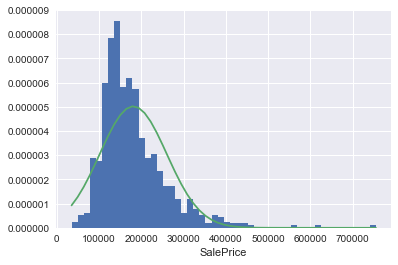

In [9]:
#Distribution of saleprice
import matplotlib.mlab as mlab
n, bins, patches = plt.hist(house.SalePrice, 50, normed=1)
mu = np.mean(house.SalePrice)
sigma = np.std(house.SalePrice)
plt.plot(bins, mlab.normpdf(bins, mu, sigma)) 
plt.xlabel("SalePrice")

{'boxes': [<matplotlib.lines.Line2D at 0x11a6755d0>],
 'caps': [<matplotlib.lines.Line2D at 0x11a682450>,
 'fliers': [<matplotlib.lines.Line2D at 0x11a7f1750>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11a7f1110>],
 'whiskers': [<matplotlib.lines.Line2D at 0x10d25f850>,
  <matplotlib.lines.Line2D at 0x11a675dd0>]}

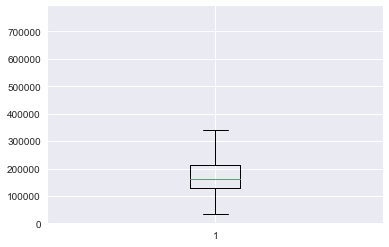

In [10]:
# #boxplot
fig = plt.figure() 
plt.boxplot(house.SalePrice)
#plt.boxplot(house.Neighborhood)

In [11]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = house.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice        1.000
OverallQual      0.791
GrLivArea        0.709
GarageCars       0.640
GarageArea       0.623
TotalBsmtSF      0.614
1stFlrSF         0.606
FullBath         0.561
TotRmsAbvGrd     0.534
YearBuilt        0.523
YearRemodAdd     0.507
GarageYrBlt      0.486
MasVnrArea       0.477
Fireplaces       0.467
BsmtFinSF1       0.386
LotFrontage      0.352
WoodDeckSF       0.324
2ndFlrSF         0.319
OpenPorchSF      0.316
HalfBath         0.284
LotArea          0.264
BsmtFullBath     0.227
BsmtUnfSF        0.214
BedroomAbvGr     0.168
ScreenPorch      0.111
PoolArea         0.092
MoSold           0.046
3SsnPorch        0.045
BsmtFinSF2      -0.011
BsmtHalfBath    -0.017
MiscVal         -0.021
LowQualFinSF    -0.026
YrSold          -0.029
OverallCond     -0.078
MSSubClass      -0.084
EnclosedPorch   -0.129
KitchenAbvGr    -0.136
Name: SalePrice, dtype: float64


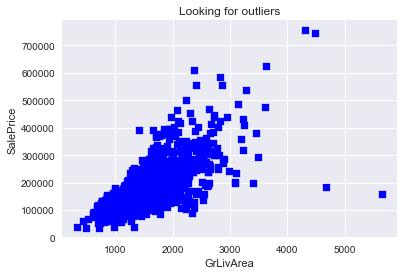

In [12]:
# let us group them together for better understanding.
#let us find outliers
plt.scatter(house.GrLivArea, house.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()



In [13]:
#we can find outliers for saleprice>4000.so let us take only columns which has <4000
house = house[house.GrLivArea < 4000]

In [14]:
#only residential area houses are needed to be taken
value_list = ['RL','FV', 'RH','RM']
house=house[house.MSZoning.isin(value_list)]

In [15]:
print house.shape

(1446, 80)


In [16]:
house['SalePrice'].mean()

180881.6846473029

In [17]:
#Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.
house.SalePrice = np.log1p(house.SalePrice)
y=house.SalePrice
house['SalePrice'].mean()

12.028198981265367

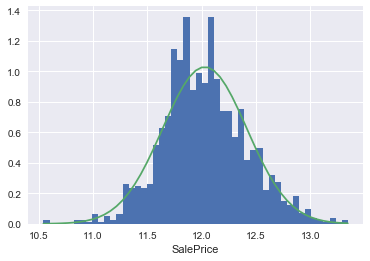

In [18]:
#Distribution of saleprice after taking into log
import matplotlib.mlab as mlab
n, bins, patches = plt.hist(house.SalePrice, 50, normed=1)
mu = np.mean(house.SalePrice)
sigma = np.std(house.SalePrice)
plt.plot(bins, mlab.normpdf(bins, mu, sigma)) 
plt.xlabel("SalePrice")

{'boxes': [<matplotlib.lines.Line2D at 0x117f3f5d0>],
 'caps': [<matplotlib.lines.Line2D at 0x117f4d450>,
 'fliers': [<matplotlib.lines.Line2D at 0x11acc7750>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11acc7110>],
 'whiskers': [<matplotlib.lines.Line2D at 0x117615ed0>,
  <matplotlib.lines.Line2D at 0x117f3fdd0>]}

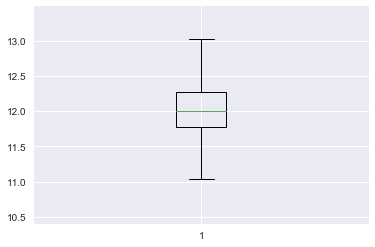

In [19]:
#boxplot
fig = plt.figure() 
plt.boxplot(house.SalePrice)

In [20]:
#Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
house.loc[:, "Alley"] = house.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
house.loc[:, "BedroomAbvGr"] = house.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
house.loc[:, "BsmtQual"] = house.loc[:, "BsmtQual"].fillna("No")
house.loc[:, "BsmtCond"] = house.loc[:, "BsmtCond"].fillna("No")
house.loc[:, "BsmtExposure"] = house.loc[:, "BsmtExposure"].fillna("No")
house.loc[:, "BsmtFinType1"] = house.loc[:, "BsmtFinType1"].fillna("No")
house.loc[:, "BsmtFinType2"] = house.loc[:, "BsmtFinType2"].fillna("No")
house.loc[:, "BsmtFullBath"] = house.loc[:, "BsmtFullBath"].fillna(0)
house.loc[:, "BsmtHalfBath"] = house.loc[:, "BsmtHalfBath"].fillna(0)
house.loc[:, "BsmtUnfSF"] = house.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
house.loc[:, "CentralAir"] = house.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
house.loc[:, "Condition1"] = house.loc[:, "Condition1"].fillna("Norm")
house.loc[:, "Condition2"] = house.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
house.loc[:, "EnclosedPorch"] = house.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
house.loc[:, "ExterCond"] = house.loc[:, "ExterCond"].fillna("TA")
house.loc[:, "ExterQual"] = house.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
house.loc[:, "Fence"] = house.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
house.loc[:, "FireplaceQu"] = house.loc[:, "FireplaceQu"].fillna("No")
house.loc[:, "Fireplaces"] = house.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
house.loc[:, "Functional"] = house.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
house.loc[:, "GarageType"] = house.loc[:, "GarageType"].fillna("No")
house.loc[:, "GarageFinish"] = house.loc[:, "GarageFinish"].fillna("No")
house.loc[:, "GarageQual"] = house.loc[:, "GarageQual"].fillna("No")
house.loc[:, "GarageCond"] = house.loc[:, "GarageCond"].fillna("No")
house.loc[:, "GarageArea"] = house.loc[:, "GarageArea"].fillna(0)
house.loc[:, "GarageCars"] = house.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
house.loc[:, "HalfBath"] = house.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
house.loc[:, "HeatingQC"] = house.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
house.loc[:, "KitchenAbvGr"] = house.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
house.loc[:, "KitchenQual"] = house.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
house.loc[:, "LotFrontage"] = house.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
house.loc[:, "LotShape"] = house.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
house.loc[:, "MasVnrType"] = house.loc[:, "MasVnrType"].fillna("None")
house.loc[:, "MasVnrArea"] = house.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
house.loc[:, "MiscFeature"] = house.loc[:, "MiscFeature"].fillna("No")
house.loc[:, "MiscVal"] = house.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
house.loc[:, "OpenPorchSF"] = house.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
house.loc[:, "PavedDrive"] = house.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
house.loc[:, "PoolQC"] = house.loc[:, "PoolQC"].fillna("No")
house.loc[:, "PoolArea"] = house.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
house.loc[:, "SaleCondition"] = house.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
house.loc[:, "ScreenPorch"] = house.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
house.loc[:, "TotRmsAbvGrd"] = house.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
house.loc[:, "Utilities"] = house.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
house.loc[:, "WoodDeckSF"] = house.loc[:, "WoodDeckSF"].fillna(0)


In [21]:
# Some numerical features are actually really categories
house= house.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [22]:
 #Encode some categorical features as ordered numbers when there is information in the order
    #pd.get_dummies
house = house.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

In [23]:
# Create new features
# 1* Simplifications of existing features
house["SimplOverallQual"] = house.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
house["SimplOverallCond"] = house.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
house["SimplPoolQC"] = house.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
house["SimplGarageCond"] = house.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
house["SimplGarageQual"] = house.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
house["SimplFireplaceQu"] = house.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
house["SimplFireplaceQu"] = house.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
house["SimplFunctional"] = house.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
house["SimplKitchenQual"] = house.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
house["SimplHeatingQC"] = house.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
house["SimplBsmtFinType1"] = house.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
house["SimplBsmtFinType2"] = house.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
house["SimplBsmtCond"] = house.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
house["SimplBsmtQual"] = house.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
house["SimplExterCond"] = house.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
house["SimplExterQual"] = house.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })


In [24]:
# Overall quality of the house
house["OverallGrade"] = house["OverallQual"] * house["OverallCond"]
# Overall quality of the garage
house["GarageGrade"] = house["GarageQual"] * house["GarageCond"]
# Overall quality of the exterior
house["ExterGrade"] = house["ExterQual"] * house["ExterCond"]
# Overall kitchen score
house["KitchenScore"] = house["KitchenAbvGr"] * house["KitchenQual"]
# Overall fireplace score
house["FireplaceScore"] = house["Fireplaces"] * house["FireplaceQu"]
# Overall garage score
house["GarageScore"] = house["GarageArea"] * house["GarageQual"]
# Overall pool score
house["PoolScore"] = house["PoolArea"] * house["PoolQC"]
# Simplified overall quality of the house
house["SimplOverallGrade"] = house["SimplOverallQual"] * house["SimplOverallCond"]
# Simplified overall quality of the exterior
house["SimplExterGrade"] = house["SimplExterQual"] * house["SimplExterCond"]
# Simplified overall pool score
house["SimplPoolScore"] = house["PoolArea"] * house["SimplPoolQC"]
# Simplified overall garage score
house["SimplGarageScore"] = house["GarageArea"] * house["SimplGarageQual"]
# Simplified overall fireplace score
house["SimplFireplaceScore"] = house["Fireplaces"] * house["SimplFireplaceQu"]
# Simplified overall kitchen score
house["SimplKitchenScore"] = house["KitchenAbvGr"] * house["SimplKitchenQual"]
# Total number of bathrooms
house["TotalBath"] = house["BsmtFullBath"] + (0.5 * house["BsmtHalfBath"]) +house["FullBath"] + (0.5 * house["HalfBath"])
# Total SF for house (incl. basement)
house["AllSF"] = house["GrLivArea"] + house["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
house["AllFlrsSF"] = house["1stFlrSF"] + house["2ndFlrSF"]
# Total SF for porch
house["AllPorchSF"] = house["OpenPorchSF"] + house["EnclosedPorch"] +house["3SsnPorch"] + house["ScreenPorch"]
# Has masonry veneer or not
house["HasMasVnr"] = house.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
house["BoughtOffPlan"] = house.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})


In [25]:
clean_house= house[["OverallGrade","GarageGrade","ExterGrade","KitchenScore","FireplaceScore","GarageScore","PoolScore",
                   "SimplOverallGrade","SimplExterGrade","SimplPoolScore","SimplGarageScore","SimplFireplaceScore","SimplKitchenScore",
                   "TotalBath","AllSF","AllFlrsSF","AllPorchSF","HasMasVnr","BoughtOffPlan"]]

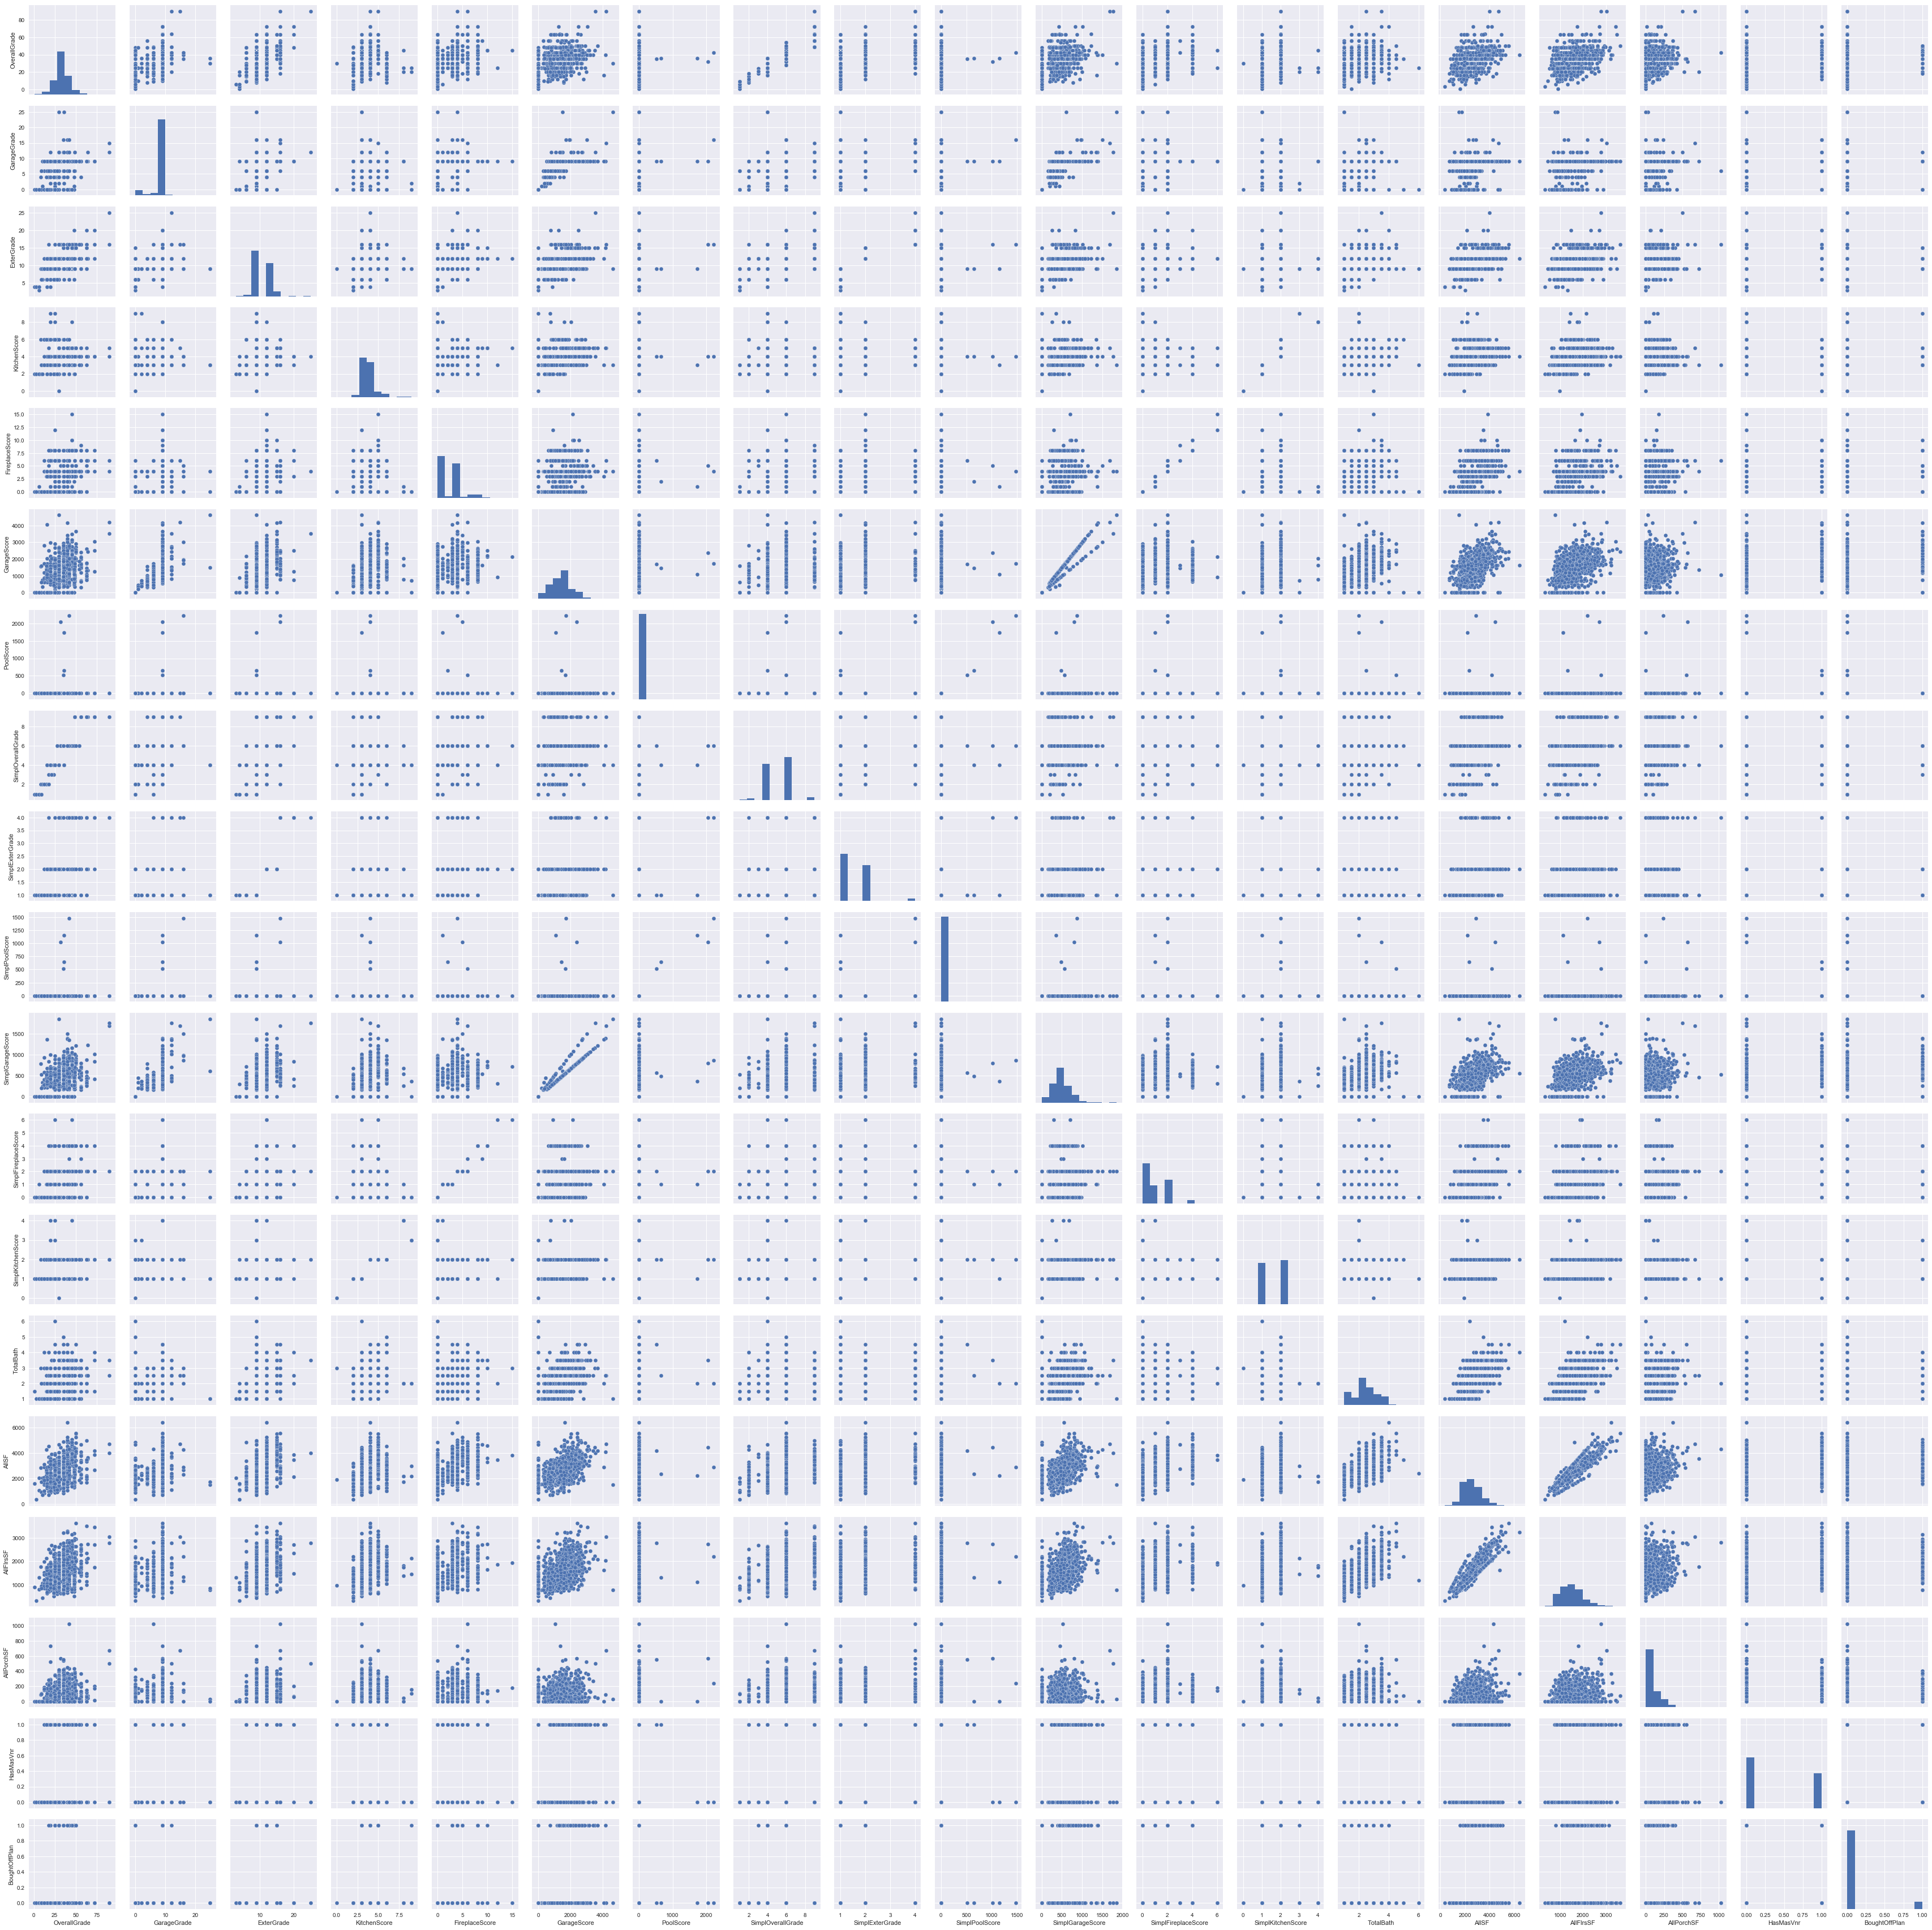

In [26]:
sns.pairplot(clean_house)

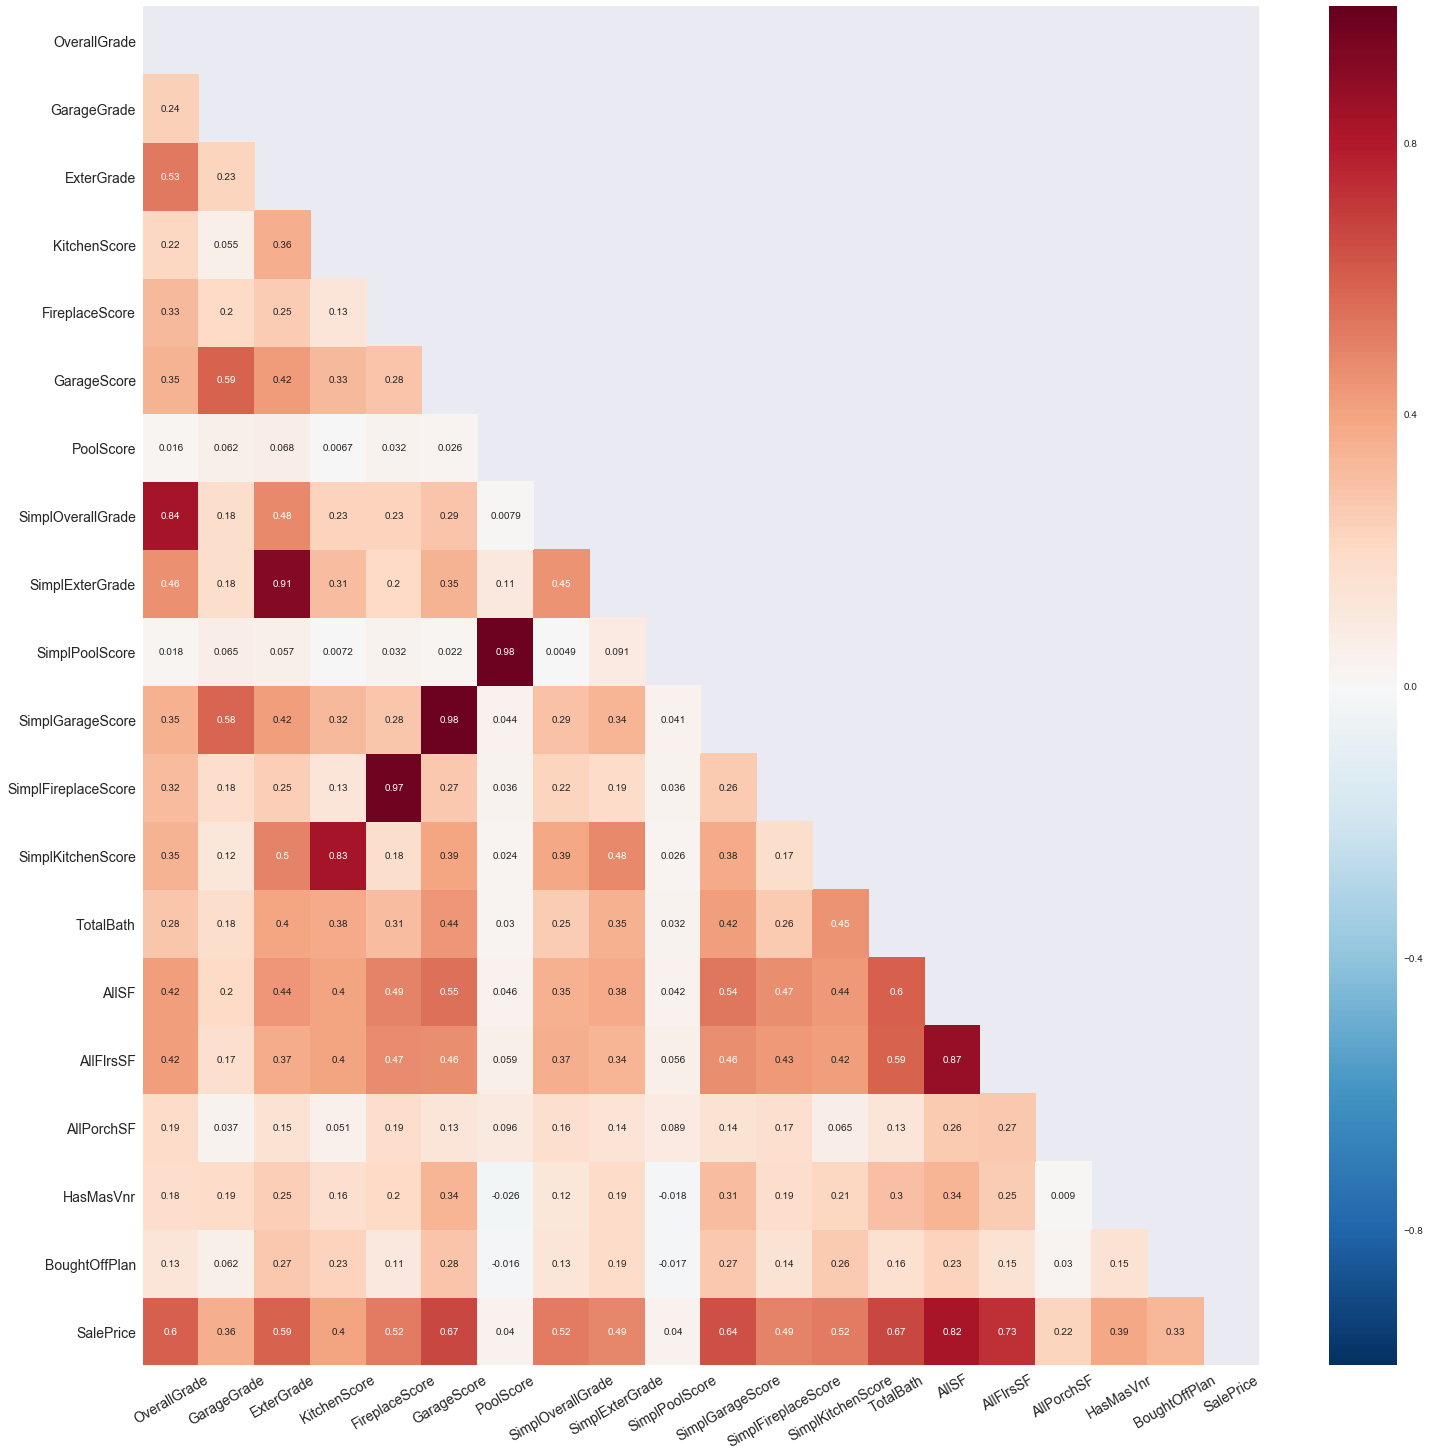

In [27]:
#heat map
def correlation_heat_map(clean_house):
    corrs = clean_house.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(25,25))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

df_with_target = clean_house.copy()
df_with_target['SalePrice'] = y
correlation_heat_map(df_with_target)


In [28]:
# heat map in numerical output
# Find most important features relative to target
print("Find most important features relative to target")
corr = house.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice            1.000
AllSF                0.822
OverallQual          0.819
AllFlrsSF            0.733
GrLivArea            0.723
SimplOverallQual     0.709
GarageCars           0.688
ExterQual            0.683
GarageScore          0.670
TotalBath            0.670
KitchenQual          0.669
GarageArea           0.668
TotalBsmtSF          0.644
SimplGarageScore     0.642
SimplExterQual       0.639
BsmtQual             0.621
1stFlrSF             0.613
SimplKitchenQual     0.611
OverallGrade         0.596
SimplBsmtQual        0.595
FullBath             0.587
ExterGrade           0.586
YearBuilt            0.585
YearRemodAdd         0.563
GarageYrBlt          0.547
FireplaceQu          0.546
TotRmsAbvGrd         0.535
SimplKitchenScore    0.522
SimplOverallGrade    0.522
FireplaceScore       0.518
                     ...  
AllPorchSF           0.222
SimplBsmtCond        0.208
BedroomAbvGr         0.194
LotFrontage          0.183
SimplFu

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [29]:
# A:create new features
house["OverallQual-s2"] = house["OverallQual"] ** 2
house["OverallQual-s3"] = house["OverallQual"] ** 3
house["OverallQual-Sq"] = np.sqrt(house["OverallQual"])
house["AllSF-2"] = house["AllSF"] ** 2
house["AllSF-3"] = house["AllSF"] ** 3
house["AllSF-Sq"] = np.sqrt(house["AllSF"])
house["AllFlrsSF-2"] = house["AllFlrsSF"] ** 2
house["AllFlrsSF-3"] = house["AllFlrsSF"] ** 3
house["AllFlrsSF-Sq"] = np.sqrt(house["AllFlrsSF"])
house["GrLivArea-2"] = house["GrLivArea"] ** 2
house["GrLivArea-3"] = house["GrLivArea"] ** 3
house["GrLivArea-Sq"] = np.sqrt(house["GrLivArea"])
house["SimplOverallQual-s2"] = house["SimplOverallQual"] ** 2
house["SimplOverallQual-s3"] = house["SimplOverallQual"] ** 3
house["SimplOverallQual-Sq"] = np.sqrt(house["SimplOverallQual"])
house["ExterQual-2"] = house["ExterQual"] ** 2
house["ExterQual-3"] = house["ExterQual"] ** 3
house["ExterQual-Sq"] = np.sqrt(house["ExterQual"])
house["GarageCars-2"] = house["GarageCars"] ** 2
house["GarageCars-3"] = house["GarageCars"] ** 3
house["GarageCars-Sq"] = np.sqrt(house["GarageCars"])
house["TotalBath-2"] = house["TotalBath"] ** 2
house["TotalBath-3"] = house["TotalBath"] ** 3
house["TotalBath-Sq"] = np.sqrt(house["TotalBath"])
house["KitchenQual-2"] = house["KitchenQual"] ** 2
house["KitchenQual-3"] = house["KitchenQual"] ** 3
house["KitchenQual-Sq"] = np.sqrt(house["KitchenQual"])
house["GarageScore-2"] = house["GarageScore"] ** 2
house["GarageScore-3"] = house["GarageScore"] ** 3
house["GarageScore-Sq"] = np.sqrt(house["GarageScore"])


In [30]:
#we have some columns with numerical values and some with categories
# Differentiate numerical features (minus the target) and categorical features
categorical_features = house.select_dtypes(include = ["object"]).columns
numerical_features = house.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
house_num = house[numerical_features]
house_cat = house[categorical_features]

Numerical features : 117
Categorical features : 26


In [31]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in house : " + str(house_num.isnull().values.sum()))
house_num = house_num.fillna(house_num.median())
print("Remaining NAs for numerical features in train : " + str(house_num.isnull().values.sum()))

NAs for numerical features in house : 79
Remaining NAs for numerical features in train : 0


In [32]:
# Log transform of the skewed numerical features to lessen impact of outliers
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
from scipy.stats import skew
skewness = house_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
house_num[skewed_features] = np.log1p(house_num[skewed_features])

87 skewed numerical features to log transform


In [33]:
# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in house : " + str(house_cat.isnull().values.sum()))
house_cat = pd.get_dummies(house_cat)
print("Remaining NAs for categorical features in train : " + str(house_cat.isnull().values.sum()))

NAs for categorical features in house : 1
Remaining NAs for categorical features in train : 0


In [34]:
#Data Modeling
# Join categorical and numerical features
from sklearn.model_selection import train_test_split
house=house[house['YrSold']==2010]
house = pd.concat([house_num, house_cat], axis = 1)
print("New number of features : " + str(house.shape[1]))


New number of features : 318


In [47]:

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(house, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1012, 318)
X_test : (434, 318)
y_train : (1012,)
y_test : (434,)


In [36]:
# Standardize numerical features
from sklearn.preprocessing import StandardScaler
stdSc = StandardScaler()
X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])

//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [37]:
# A:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [38]:
house.columns

Index([u'LotFrontage', u'LotArea', u'Street', u'LotShape', u'Utilities',
       u'LandSlope', u'OverallQual', u'OverallCond', u'YearBuilt',
       u'YearRemodAdd',
       ...
       u'SaleType_ConLw', u'SaleType_New', u'SaleType_Oth', u'SaleType_WD',
       u'SaleCondition_Abnorml', u'SaleCondition_AdjLand',
       u'SaleCondition_Alloca', u'SaleCondition_Family',
       u'SaleCondition_Normal', u'SaleCondition_Partial'],
      dtype='object', length=318)

In [39]:
# Linear Regression with out Regularisation

In [40]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

('RMSE on Training set :', 0.55468242291555281)
('RMSE on Test set :', 73529570617.18071)


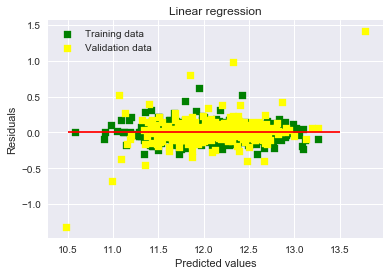

In [51]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "green", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "yellow", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

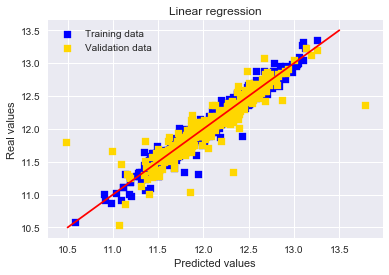

In [50]:
# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "gold", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [43]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

('Best alpha :', 30.0)
Try again for more precision with alphas centered around 30.0
('Best alpha :', 31.5)
('Ridge RMSE on Training set :', 0.10706822309677003)
('Ridge RMSE on Test set :', 0.11461712780025284)


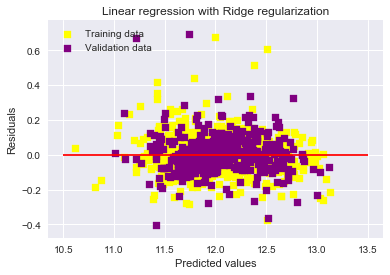

In [49]:
# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "yellow", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "purple", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

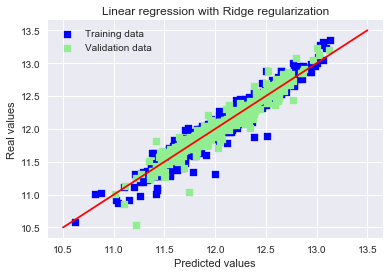

In [45]:
# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Ridge picked 310 features and eliminated the other 8 features


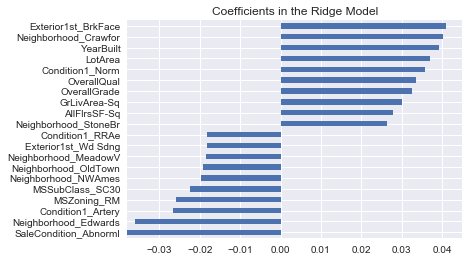

In [46]:
# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

In [52]:
#Linear Regression with Lasso regularization (L1 penalty)

In [ ]:
#Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)


('Best alpha :', 0.00059999999999999995)
Try again for more precision with alphas centered around 0.0006
('Best alpha :', 0.00066)
('Lasso RMSE on Training set :', 0.10677109138979039)


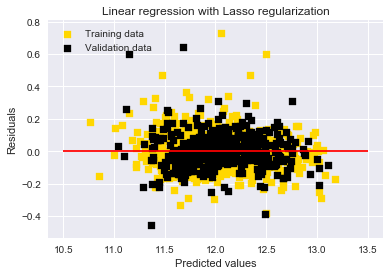

In [60]:
# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "gold", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "black", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

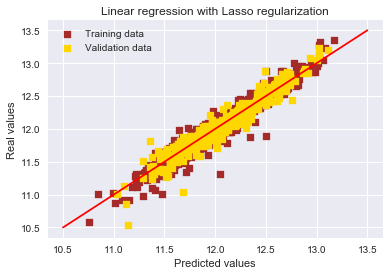

In [62]:
# Plot predictions
plt.scatter(y_train_las, y_train, c = "brown", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "gold", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Lasso picked 89 features and eliminated the other 229 features


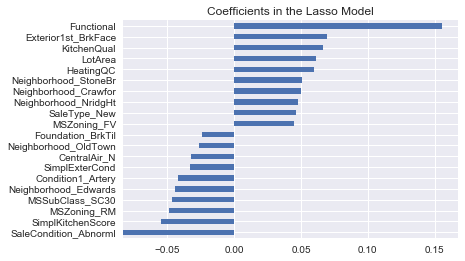

In [64]:
# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

In [ ]:
#Linear Regression with ElasticNet regularization (L1 and L2 penalty)

In [ ]:
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet).mean())
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet).mean())
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

In [ ]:
# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "gold", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "maroon", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

In [ ]:
# Plot predictions
plt.scatter(y_train, y_train_ela, c = "ligthgreen", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "pink", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [ ]:
# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

In [ ]:
# from the above plots it is clear that Sale Condition is abnormal due to listed factors